# **Andrej Karpathy Micrograd Tutorial**
## [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&t=969s)

___

In [71]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
def f(x):
    return 3*x**2 - 4*x + 5

In [73]:
f(3.0)

20.0

In [74]:
xs = np.arange(-5,5,0.25)
ys = f(xs)

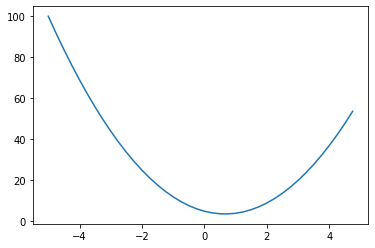

In [75]:
plt.plot(xs,ys)

# what is the derivative at different points on this curve?

In [76]:
h = 0.001
xs = [3,-3]
# definition of derivative
[(f(x+h) - f(x))/h for x in xs]
# at 3 it has positive slope and at -3 it has negative slope

[14.00300000000243, -21.996999999998934]

In [77]:
# slightly more complex stuff:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d

4.0

In [78]:
h = 0.0001

# wrt a
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c

a += h
d2 = a*b + c
print(f"a -> d1: {d1}, d2: {d2}, slope: {(d2-d1)/h}")

# wrt b
a = 2.0
b = -3.0
c = 10.0

b += h
d2 = a*b + c
print(f"b -> d1: {d1}, d2: {d2}, slope: {(d2-d1)/h}")

# wrt c
a = 2.0
b = -3.0
c = 10.0
c += h
d2 = a*b + c

print(f"c -> d1: {d1}, d2: {d2}, slope: {(d2-d1)/h}")

a -> d1: 4.0, d2: 3.999699999999999, slope: -3.000000000010772
b -> d1: 4.0, d2: 4.0002, slope: 2.0000000000042206
c -> d1: 4.0, d2: 4.0001, slope: 0.9999999999976694


___


# Micrograd

In [79]:
class Value:
    
    def __init__(self,data, _children = (), _op='', label=''):
        self.data = data
        self.grad = 0.0 # 0 = no effect
        self._prev = set(_children)
        self._op = _op
        self.label = label

    
    def __repr__(self):
        return f"Value(data={self.data})"

    # addition: internally a.__add__(b)
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    # multiplication
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

In [80]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label = 'c')
d = a*b
d.label = 'd'
e = d + c
e.label = 'e'
print(e, e._prev, e._op)

Value(data=4.0) {Value(data=10), Value(data=-6.0)} +


# Visualizing the equation

In [81]:
from graphviz import Digraph

def trace(root):
    # builds set of all nodes and edges in graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # LR: left -> right
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for value - create rectangular 'record' node
        dot.node(name=uid, 
                 label = f"{n.label} | data: {n.data:.4f} | grad: {n.grad:.4f}", 
                 shape='record'
                )
        
        # if result of an operation, create operator node
        if n._op:
            dot.node(name=uid+n._op, label = n._op)
            dot.edge(uid+n._op, uid)

    for n1,n2 in edges:
        # connect n1 -> op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)

    return dot

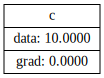

In [82]:
draw_dot(c)

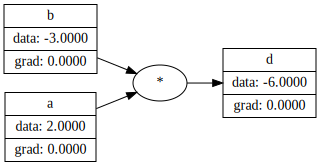

In [83]:
draw_dot(d)

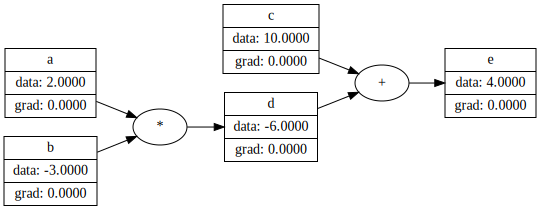

In [84]:
draw_dot(e)

In [85]:
f =  Value(-2.0, label='f')
L = e*f
L.label = 'L'
L

Value(data=-8.0)

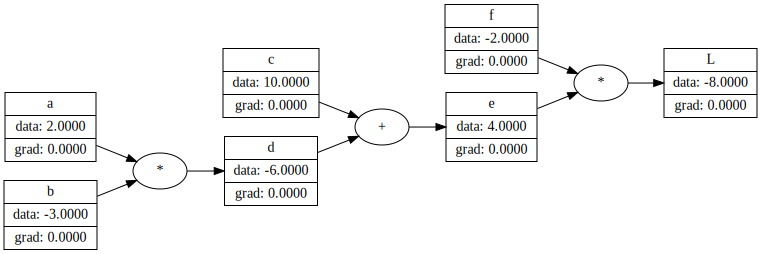

In [86]:
draw_dot(L)

In [87]:
L._prev

{Value(data=-2.0), Value(data=4.0)}

# in backpropagation, we'll find the derivative of L wrt all the previous nodes

beginning from L

## Manual Backprop

In [88]:
def derive():
    # L = e*f
    # e = d + c
    # d = a*b 
    # L = (a*b + c)*f

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label = 'c')

    d = a*b
    d.label = 'd'

    e = d + c
    e.label = 'e'

    f =  Value(-2.0, label='f')

    L = e*f
    L.label = 'L'

    L1 = L.data

    # --------- wrt a

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label = 'c')
    d = a*b
    d.label = 'd'
    e = d + c
    e.label = 'e'
    f =  Value(-2.0, label='f')
    L = e*f
    L.label = 'L'

    L2 = L.data

    print("derivative of L wrt a: ",(L2 - L1)/h)

    # --------- wrt L

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label = 'c')
    d = a*b
    d.label = 'd'
    e = d + c
    e.label = 'e'
    f =  Value(-2.0, label='f')
    L = e*f
    L.label = 'L'

    L2 = L.data + h

    # close to 1 since derivative of anything by itself = 1
    print("derivative of L wrt L: ",(L2 - L1)/h)


In [89]:
derive()

derivative of L wrt a:  6.000000000021544
derivative of L wrt L:  0.9999999999976694


In [90]:
# so we can set the grad value of L = 1
L.grad = 1

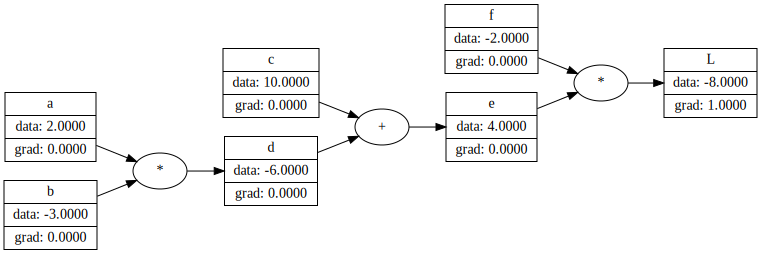

In [91]:
draw_dot(L)

```
lets begin with e
we know that L = e*f
we need to find dL/de // partial derivative
dL/de = f (in partial derivatives, all other vars are constant except e)
dL/de = (L(x+h)-L(x)) / h
      = ((e+h)*f - e*f) / h
      = h*f/h
      = f

and similarly

dL/df = e
```

In [92]:
f.grad = e.data
e.grad = f.data

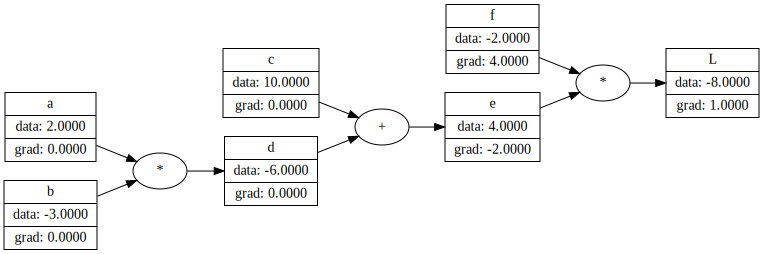

In [93]:
draw_dot(L)

In [94]:
# cross-checking via the formula
def derive():
    # L = e*f
    # e = d + c
    # d = a*b 
    # L = (a*b + c)*f

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label = 'c')

    d = a*b
    d.label = 'd'

    e = d + c
    e.label = 'e'

    f =  Value(-2.0, label='f')

    L = e*f
    L.label = 'L'

    L1 = L.data

    # --------- wrt f

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label = 'c')
    d = a*b
    d.label = 'd'
    e = d + c
    e.label = 'e'
    f =  Value(-2.0 + h, label='f')
    L = e*f
    L.label = 'L'

    L2 = L.data

    print("derivative of L wrt f: ",(L2 - L1)/h)

    # --------- wrt e

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label = 'c')
    d = a*b
    d.label = 'd'
    e = d + c
    e.data += h
    e.label = 'e'
    f =  Value(-2.0, label='f')
    L = e*f
    L.label = 'L'

    L2 = L.data

    print("derivative of L wrt e: ",(L2 - L1)/h)


In [95]:
derive()

derivative of L wrt f:  3.9999999999995595
derivative of L wrt e:  -1.9999999999953388


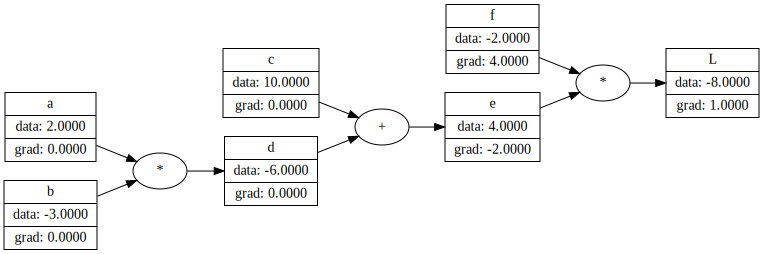

In [96]:
draw_dot(L)

```
now the important nodes: d and c

dL/dc = ?

wkt, e = c + d
de/dc  = 1 // partial
de/dd  = 1

TIME FOR THE CHAIN RULE!!!!!!

if z depends on y and y depends on x
then z depends on x as well
hence:

dz/dx = dz/dy * dy/dx

intuitive:

car is 2 times faster than bike
bike is 4 times faster than walking
then car is 2*4=8 times faster than walking
```

```
so now:
we want dL/dc

wkt:
dL/de = -2
de/dc = 1
de/dd = 1

therefore from chain rule:

dL/dc = dL/de * de/dc
dL/dc = -2 * 1
      = -2
      = dL/de

dL/dd = dL/de * de/dd
      = -2 * 1
      = -2
      = dL/de
```

In [97]:
c.grad = e.grad
d.grad = e.grad

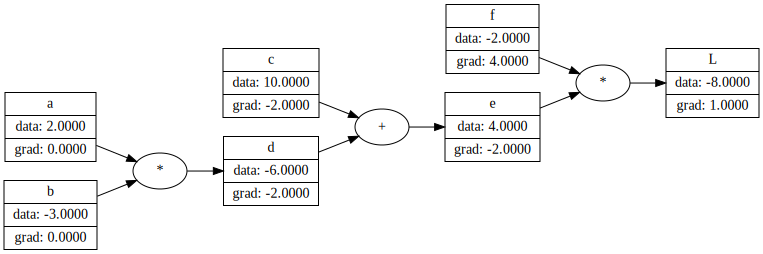

In [98]:
draw_dot(L)

In [99]:
# cross-checking via the formula
def derive():
    # L = e*f
    # e = d + c
    # d = a*b 
    # L = (a*b + c)*f

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label = 'c')

    d = a*b
    d.label = 'd'

    e = d + c
    e.label = 'e'

    f =  Value(-2.0, label='f')

    L = e*f
    L.label = 'L'

    L1 = L.data

    # --------- wrt c

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10 + h, label = 'c')
    d = a*b
    d.label = 'd'
    e = d + c
    e.label = 'e'
    f =  Value(-2.0, label='f')
    L = e*f
    L.label = 'L'

    L2 = L.data

    print("derivative of L wrt c: ",(L2 - L1)/h)

    # --------- wrt d

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label = 'c')
    d = a*b
    d.data += h
    d.label = 'd'
    e = d + c
    e.label = 'e'
    f =  Value(-2.0, label='f')
    L = e*f
    L.label = 'L'

    L2 = L.data

    print("derivative of L wrt d: ",(L2 - L1)/h)


In [100]:
derive() # verified

derivative of L wrt c:  -1.9999999999953388
derivative of L wrt d:  -1.9999999999953388


```
time for nodes a and b
chain rule again

dL/dd = -2
dL/da = ?
dL/db = ?

d = a*b
dd/da = b = -3
dd/db = a = 2

therefore

dL/da = dL/dd * dd/da
      = -2 * -3
      = 6

dL/db = dL/dd * dd/db
      = -2 * 2
      = -4
```

In [101]:
a.grad = d.grad * b.data
b.grad = d.grad * a.data

In [102]:
# cross-checking via the formula
def derive():
    # L = e*f
    # e = d + c
    # d = a*b 
    # L = (a*b + c)*f

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label = 'c')

    d = a*b
    d.label = 'd'

    e = d + c
    e.label = 'e'

    f =  Value(-2.0, label='f')

    L = e*f
    L.label = 'L'

    L1 = L.data

    # --------- wrt a

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label = 'c')
    d = a*b
    d.label = 'd'
    e = d + c
    e.label = 'e'
    f =  Value(-2.0, label='f')
    L = e*f
    L.label = 'L'

    L2 = L.data

    print("derivative of L wrt a: ",(L2 - L1)/h)

    # --------- wrt b

    a = Value(2.0, label='a')
    b = Value(-3.0 + h, label='b')
    c = Value(10, label = 'c')
    d = a*b
    d.label = 'd'
    e = d + c
    e.label = 'e'
    f =  Value(-2.0, label='f')
    L = e*f
    L.label = 'L'

    L2 = L.data

    print("derivative of L wrt b: ",(L2 - L1)/h)


In [103]:
derive() # verified

derivative of L wrt a:  6.000000000021544
derivative of L wrt b:  -4.000000000008441


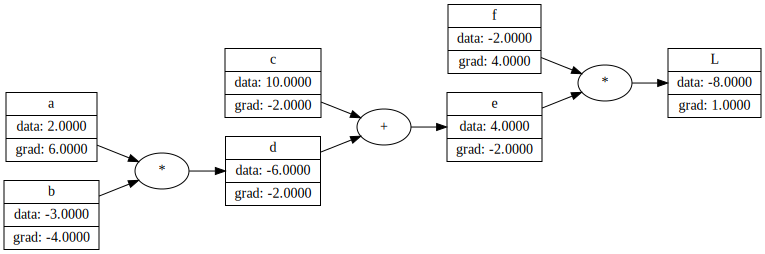

In [104]:
draw_dot(L)

# Optimization step

In [105]:
step_size = 0.01

a.data += step_size * a.grad
b.data += step_size * b.grad
c.data += step_size * c.grad
f.data += step_size * f.grad

# forward prop
d = a*b
e = d+c
L = e*f

In [106]:
L.data

-7.286496

___